# Recommendation Systems

![Alt text](Images\Becauseyouwatched.jpg)

## BUSINESS UNDERSTANDING.

## Business Overview.

Imagine the number of streaming sites, now imagine the challenges the platform faces: the two main questions being how do they get to help  users discover content they will not only love but also will keep them engaged over time- remember there are thousands of titles available as such users could experience decision fatigue which may lead to lower watch time and or increased churn. Now how about having a well-designed recommendation system that can transform this experience by only surfacing relevant and personalized content that resonates with one's individual taste and preference?

This project is therefore designed to build a movie recommendation engine using the MovieLens dataset, with the aim of improving the retention of users through personalized suggestions and we shall do so by analyzing the user ratings and preferences. In the end we shall be able to deliver top five movie recommendations that feel intuitive, relevant and engaging.

## Problem statement.

As we have seen that its really a struggle by users to find content that matches their prefences, especially as more movies gets produced each day. Therefore our question is ***'how can we deliver personalized movie recommendations that will ultimately increase user satsifaction and retention on a streaming platform?'***

## Stakeholders

**Product team**- to improve user engagement & retention through personalization  
**Data Scientist**- For building and validating recommendation engine  
**Marketing team**- for segmentation and promotion of contetnt based on preferences  
**Owners of streaming platforms/ Executive leadership**- Evaluation of ROI of a well designed personalized system on platform performance.


## Success Metrics.
- Building a model that generates top five movie recommendations per user.
- Improvement of user engagement as a result of tailor-making contetnt to user preferences.
- Provision of actionable insights for product and marketing team to use.
- Visualizing resulsts for non technical team e.g the executive.


## Type of Recommendation and Model Evaluation Metrics.
This project will be focusing on personalized recommendations, leveraging collaborative filtering to unearth latent user preferances and as a result suggest movies aligned with their taste. Some of the metrics that we may deploy include:

- **RMSE/MAE** -For rating prediction accuracy
- **Precision, Recall, F1 Score** - For quality ranking.
- **Coverage, Diversity** - To help with assessment of recomendation variety & system robustness.

## Data Understanding  

### Dataset Overview  
The provided dataset, comprising four CSV files: 
- **links.csv**
- **movies.csv**
- **ratings.csv**
- **tags.csv**

 offers a comprehensive foundation for a robust movie recommendation system. The data is structured to facilitate the analysis of user behavior, movie characteristics, and their interrelationships.

##  Importing Libraries 

In [2]:
import sys
!{sys.executable} -m pip install --upgrade pip setuptools wheel
!{sys.executable} -m pip install numpy scipy cython cmake
!{sys.executable} -m pip install implicit

In [3]:
# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from implicit.als import AlternatingLeastSquares
from surprise import KNNBasic, SVD, Dataset, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
from itertools import product
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="notebook")

---
## Movies dataset.


In [4]:
# Loading  the movies dataset
movies = pd.read_csv('Data/movies.csv')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


#### Movies.csv  

This file contains **movie titles** and their corresponding **genres**.  

It, Serves as the **central movie catalog**, this file contains a unique entry for each of the **9,742 films**.  
### Columns 
- **movieId**: Primary key that links to other datasets.  
- **title**: Movie title (with release year).  
- **genres**: Pipe-separated list of genres.  

This file is essential for **content-based filtering**, enabling genre-specific recommendations and theme analysis. 

---
## Ratings Dataset.


In [5]:
# Loading ratings dataset
ratings = pd.read_csv('Data/ratings.csv')
ratings.info()
ratings.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### ratings.csv  
The most **data-heavy file**, containing **100,836 explicit user ratings**.  
#### Columns 
- **userId**: Identifier of the user.  
- **movieId**: Identifier of the rated movie.  
- **rating**: Explicit user rating (e.g., 1.0–5.0).  
- **timestamp**: Time of rating (Unix format).  

This dataset forms the **backbone of collaborative filtering**. The timestamps also enable **temporal analysis**, helping track evolving preferences and movie popularity trends.  


---
## Links dataset.


In [6]:
# Loading  the links dataset
links = pd.read_csv('Data/links.csv')
links.info()
links.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


#### links.csv  

This file serves as a **bridge to external metadata sources**, mapping internal `movieId` values to industry-standard identifiers:  
### Columns  
- **movieId**: Unique identifier for a movie.
- **imdbId**: IMDb identifier.  
- **tmdbId**: The Movie Database (TMDb) identifier. 

These external links allow for **data enrichment**, such as retrieving cast, plot, and ratings. This enhances the recommendation engine with richer context.  

## Tags Dataset.
---

In [7]:
# Loading  the tags dataset
tags = pd.read_csv('Data/tags.csv')
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


#### tags.csv  
This file contains **3,683 qualitative user-generated tags**, offering descriptive insights beyond numerical ratings.  
### Columns
- **userId**: Identifier of the user who tagged the movie.  
- **movieId**: Identifier of the tagged movie.  
- **tag**: User-generated keyword(s).  
- **timestamp**: Time the tag was applied.  

Tags capture **nuanced characteristics** that genres miss, enabling **expressive content-based models**. They also reflect how perceptions of movies **shift over time**.  


## Data Preparation

In [8]:
# Merge datasets
df = ratings.merge(movies, on='movieId', how='left') \
            .merge(tags, on=['userId', 'movieId'], how='left') \
            .merge(links, on='movieId', how='left')

In [9]:
df.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,NaN,NaN,114709,862.0
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,NaN,NaN,113228,15602.0
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller,NaN,NaN,113277,949.0
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,NaN,NaN,114369,807.0
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,NaN,NaN,114814,629.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102677 entries, 0 to 102676
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   userId       102677 non-null  int64  
 1   movieId      102677 non-null  int64  
 2   rating       102677 non-null  float64
 3   timestamp_x  102677 non-null  int64  
 4   title        102677 non-null  object 
 5   genres       102677 non-null  object 
 6   tag          3476 non-null    object 
 7   timestamp_y  3476 non-null    float64
 8   imdbId       102677 non-null  int64  
 9   tmdbId       102664 non-null  float64
dtypes: float64(3), int64(4), object(3)
memory usage: 7.8+ MB


In [11]:
df.isnull().sum()

userId             0
movieId            0
rating             0
timestamp_x        0
title              0
genres             0
tag            99201
timestamp_y    99201
imdbId             0
tmdbId            13
dtype: int64

In [12]:
print("Shape of df:", df.shape)

Shape of df: (102677, 10)


### Data Preprocessing

In [13]:
data = df
print("Data columns:", data.columns)
duplicates = data.duplicated(subset=['userId', 'movieId']).sum()
print(f"Number of duplicate userId-movieId pairs before aggregation: {duplicates}")

Data columns: Index(['userId', 'movieId', 'rating', 'timestamp_x', 'title', 'genres', 'tag',
       'timestamp_y', 'imdbId', 'tmdbId'],
      dtype='object')
Number of duplicate userId-movieId pairs before aggregation: 1841


##### Aggregate ratings, include 'title' if present

In [14]:
agg_cols = {'rating': 'mean'}
if 'title' in data.columns:
    agg_cols['title'] = 'first'
data = data.groupby(['userId', 'movieId'], as_index=False).agg(agg_cols)
duplicates_after = data.duplicated(subset=['userId', 'movieId']).sum()
print(f"Number of duplicate userId-movieId pairs after aggregation: {duplicates_after}")

Number of duplicate userId-movieId pairs after aggregation: 0


##### Create movies DataFrame

In [15]:
if 'genres' in data.columns and 'title' in data.columns:
    movies = data[['movieId', 'title', 'genres']].drop_duplicates()
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
elif 'genres' in data.columns:
    movies = data[['movieId', 'genres']].drop_duplicates()
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
    # Try to get titles from movies.csv
    movies_csv = pd.read_csv('Data/movies.csv')
    if 'title' in movies_csv.columns:
        movies = movies.merge(movies_csv[['movieId', 'title']], on='movieId', how='left')
    else:
        movies['title'] = movies['movieId'].astype(str)  # Fallback: use movieId as title
else:
    movies = pd.read_csv('Data/movies.csv')
    movies = movies[['movieId', 'title', 'genres']]
    movies['genres'] = movies['genres'].fillna('').str.replace('|', ' ')
    if 'title' not in movies.columns:
        movies['title'] = movies['movieId'].astype(str)  # Fallback: use movieId as title
movies['title'] = movies['title'].fillna(movies['movieId'].astype(str))
print("Movies columns:", movies.columns)

Movies columns: Index(['movieId', 'title', 'genres'], dtype='object')


In [16]:
user_item_matrix = data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_item_sparse = csr_matrix(user_item_matrix.values)
movies = movies[movies['movieId'].isin(user_item_matrix.columns)]
print(f"Filtered movies_df size: {len(movies)} movies")

Filtered movies_df size: 9724 movies


### Visualizations
#### 1. Histogram of Ratings

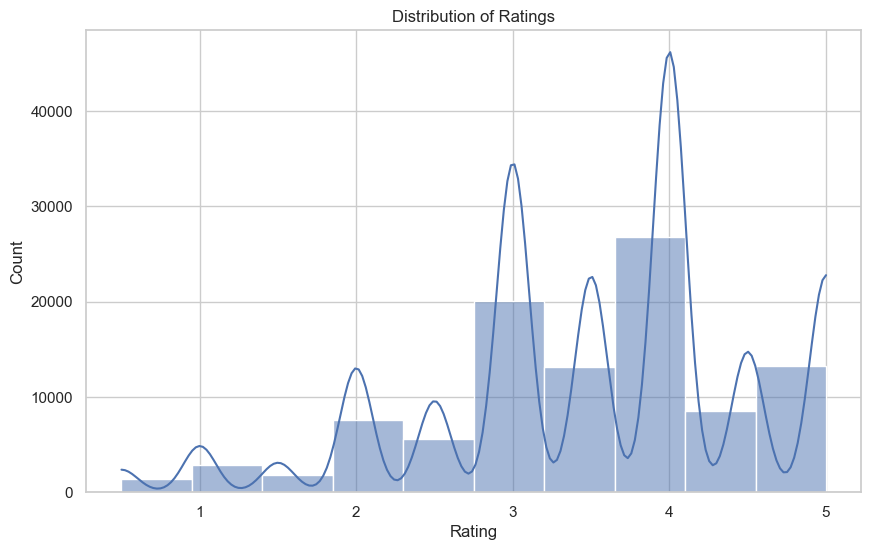

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('rating_distribution.png')
plt.show()

From this histogram, users prefer higher ratings

#### 2. Bar Plot of User Activity (Number of Ratings per User)

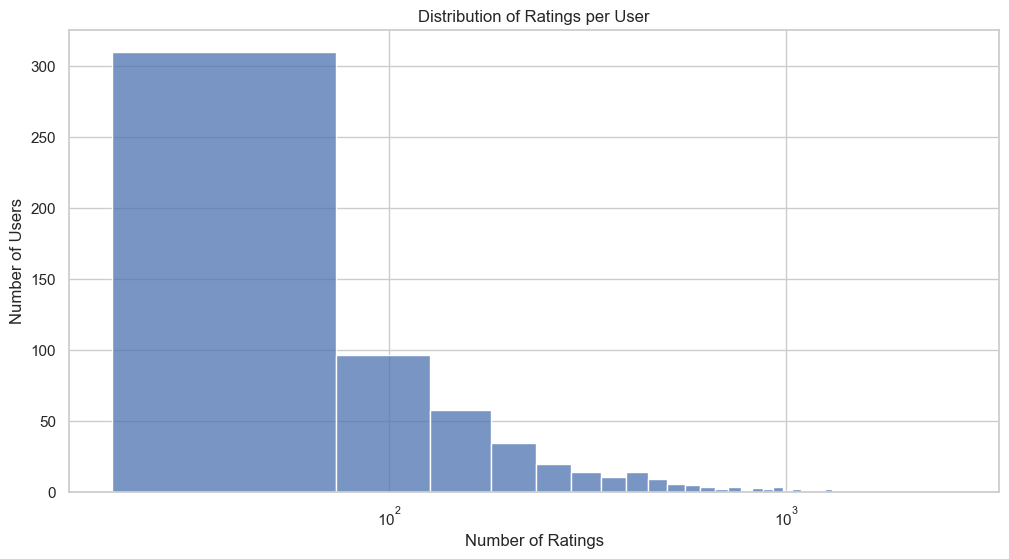

In [18]:
user_counts = data['userId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_counts, bins=50, kde=False)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.xscale('log')  # Log scale for better visualization of skewed data
plt.savefig('user_activity_distribution.png')
plt.show()

+ This bar plot displays the number of ratings per userId.
+ Most users provide few ratings, while a few are highly active.

#### 4. Bar Plot of Genre Distribution (if genres available)

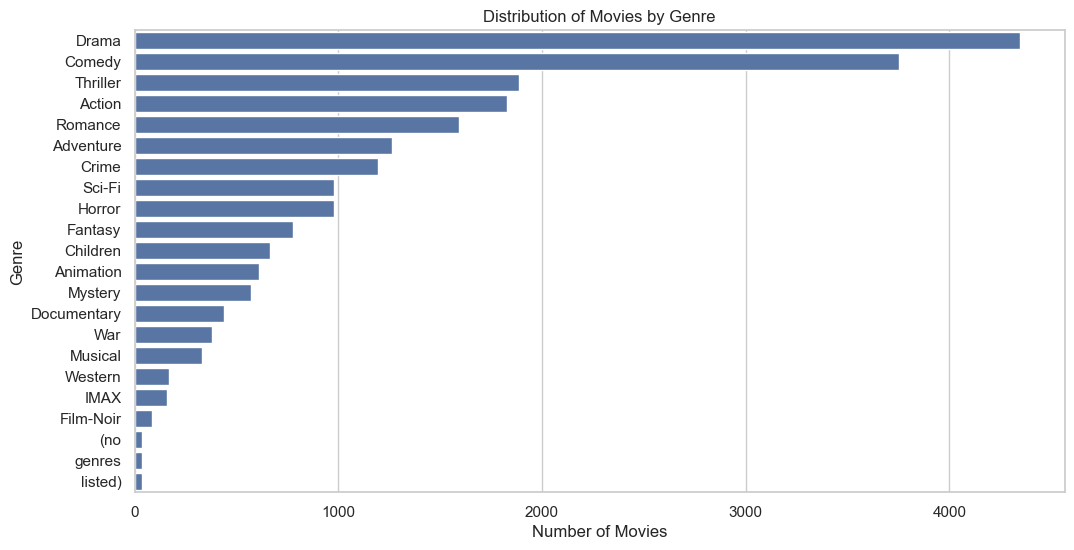

In [19]:
if 'genres' in movies.columns:
    # Split genres and count occurrences
    genre_counts = {}
    for genres in movies['genres']:
        for genre in genres.split():
            if genre:
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
    genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count']).reset_index()
    genre_df = genre_df.rename(columns={'index': 'genre'})
    genre_df = genre_df.sort_values('count', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='count', y='genre', data=genre_df)
    plt.title('Distribution of Movies by Genre')
    plt.xlabel('Number of Movies')
    plt.ylabel('Genre')
    plt.savefig('genre_distribution.png')
    plt.show()
else:
    print("Genres not available for visualization.")

+ This bar plot counts movies per genre (if genres is available).
+ Some genres (e.g., Drama, Comedy) dominate, while others (e.g., Documentary) are less common.

#### Split data for scikit-learn and implicit

In [20]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
train_sparse = csr_matrix(train_matrix.values)
test_data = test_data[test_data['movieId'].isin(train_matrix.columns)]
print(f"Test data size after filtering: {len(test_data)}")
print(f"user_item_matrix shape: {user_item_matrix.shape}")
print(f"train_sparse shape: {train_sparse.shape}")

# Split data for surprise
reader = Reader(rating_scale=(0.5, 5.0))
surprise_data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)
trainset, testset = surprise_train_test_split(surprise_data, test_size=0.2, random_state=42)

X_train = [(row['userId'], row['movieId']) for _, row in train_data.iterrows()]
y_train = train_data['rating'].values
X_test = [(row['userId'], row['movieId']) for _, row in test_data.iterrows()]
y_test = test_data['rating'].values

Test data size after filtering: 19355
user_item_matrix shape: (610, 9724)
train_sparse shape: (610, 8983)


### Model Definitions
#### KNN Recommender


In [21]:

class KNNRecommender:
    def __init__(self, k=40, sim_options=None):
        self.model = KNNBasic(k=k, sim_options=sim_options or {'name': 'cosine', 'user_based': True})
        self.trainset = None

    def fit(self, trainset):
        self.trainset = trainset
        self.model.fit(self.trainset)
        return self

    def predict(self, user_id, movie_id):
        return self.model.predict(user_id, movie_id).est

#### SVD Recommender

In [22]:
class SurpriseSVDRecommender:
    def __init__(self, n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02):
        self.model = SVD(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all, random_state=42)
        self.trainset = None

    def fit(self, trainset):
        self.trainset = trainset
        self.model.fit(self.trainset)
        return self

    def predict(self, user_id, movie_id):
        return self.model.predict(user_id, movie_id).est

def als_predict(user_id, movie_id, user_item_matrix, als_model, train_matrix):
    if movie_id not in train_matrix.columns or user_id not in train_matrix.index:
        return 0
    try:
        user_idx = train_matrix.index.get_loc(user_id)  # Use train_matrix.index
        movie_idx = train_matrix.columns.get_loc(movie_id)
        if movie_idx >= len(als_model.item_factors):
            return 0
        return np.dot(als_model.user_factors[user_idx], als_model.item_factors[movie_idx])
    except (KeyError, IndexError):
        return 0

#### ALS Recommender

In [23]:
class ALSRecommender:
    def __init__(self, factors=100, regularization=0.1, iterations=20):
        self.model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
        self.user_item_matrix = None

    def fit(self, user_item_sparse):
        self.model.fit(user_item_sparse)
        return self

    def predict(self, user_id, movie_id):
        return als_predict(user_id, movie_id, user_item_matrix, self.model, train_matrix)

### Hyperparameter Tuning and Evaluation
#### RMSE Scorer

In [24]:
def rmse_scorer(estimator, X, y):
    predictions = [estimator.predict(user_id, movie_id) for user_id, movie_id in X]
    valid = [p > 0 for p in predictions]
    if sum(valid) == 0:
        return np.inf
    return sqrt(mean_squared_error(y[valid], [p for p, v in zip(predictions, valid) if v]))

def precision_recall_at_k(predictions, k=10, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, mid, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = []
    recalls = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for _, true_r in user_ratings)
        n_rec_k = sum((est >= threshold) for est, _ in user_ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold) for _, true_r in user_ratings[:k])
        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)
    return np.mean(precisions), np.mean(recalls)

#### KNN Hyperparameter Tuning

In [25]:
knn_param_grid = {
    'k': [20, 40, 60],
    'sim_options': [
        {'name': 'cosine', 'user_based': True},
        {'name': 'pearson', 'user_based': True}
    ]
}
knn_results = []
best_knn_rmse = float('inf')
best_knn_params = None
best_knn_model = None
for k, sim_options in product(knn_param_grid['k'], knn_param_grid['sim_options']):
    knn = KNNRecommender(k=k, sim_options=sim_options)
    knn.fit(trainset)
    predictions = [(uid, iid, r_ui, knn.predict(uid, iid)) for uid, iid, r_ui in testset]
    rmse = sqrt(mean_squared_error([r_ui for _, _, r_ui, _ in predictions], [est for _, _, _, est in predictions]))
    knn_results.append({'k': k, 'sim': sim_options['name'], 'rmse': rmse})
    print(f"KNN (k={k}, sim={sim_options['name']}) RMSE: {rmse:.4f}")
    if rmse < best_knn_rmse:
        best_knn_rmse = rmse
        best_knn_params = {'k': k, 'sim_options': sim_options}
        best_knn_model = knn
print(f"Best KNN Params: {best_knn_params}, RMSE: {best_knn_rmse:.4f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN (k=20, sim=cosine) RMSE: 0.9847
Computing the pearson similarity matrix...
Done computing similarity matrix.
KNN (k=20, sim=pearson) RMSE: 0.9858
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN (k=40, sim=cosine) RMSE: 0.9823
Computing the pearson similarity matrix...
Done computing similarity matrix.
KNN (k=40, sim=pearson) RMSE: 0.9829
Computing the cosine similarity matrix...
Done computing similarity matrix.
KNN (k=60, sim=cosine) RMSE: 0.9824
Computing the pearson similarity matrix...
Done computing similarity matrix.
KNN (k=60, sim=pearson) RMSE: 0.9829
Best KNN Params: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}, RMSE: 0.9823


#### SVD Hyperparameter Tuning

In [26]:
svd_param_grid = {
    'n_factors': [50, 100, 200],
    'n_epochs': [10, 20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}
svd_results = []
best_svd_rmse = float('inf')
best_svd_params = None
best_svd_model = None
for n_factors, n_epochs, lr_all, reg_all in product(
    svd_param_grid['n_factors'],
    svd_param_grid['n_epochs'],
    svd_param_grid['lr_all'],
    svd_param_grid['reg_all']
):
    svd = SurpriseSVDRecommender(n_factors=n_factors, n_epochs=n_epochs, lr_all=lr_all, reg_all=reg_all)
    svd.fit(trainset)
    predictions = [(uid, iid, r_ui, svd.predict(uid, iid)) for uid, iid, r_ui in testset]
    rmse = sqrt(mean_squared_error([r_ui for _, _, r_ui, _ in predictions], [est for _, _, _, est in predictions]))
    svd_results.append({'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all, 'rmse': rmse})
    print(f"SVD (n_factors={n_factors}, n_epochs={n_epochs}, lr_all={lr_all}, reg_all={reg_all}) RMSE: {rmse:.4f}")
    if rmse < best_svd_rmse:
        best_svd_rmse = rmse
        best_svd_params = {'n_factors': n_factors, 'n_epochs': n_epochs, 'lr_all': lr_all, 'reg_all': reg_all}
        best_svd_model = svd
print(f"Best SVD Params: {best_svd_params}, RMSE: {best_svd_rmse:.4f}")

SVD (n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.02) RMSE: 0.8852
SVD (n_factors=50, n_epochs=10, lr_all=0.005, reg_all=0.1) RMSE: 0.8852
SVD (n_factors=50, n_epochs=10, lr_all=0.01, reg_all=0.02) RMSE: 0.8775
SVD (n_factors=50, n_epochs=10, lr_all=0.01, reg_all=0.1) RMSE: 0.8780
SVD (n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.02) RMSE: 0.8775
SVD (n_factors=50, n_epochs=20, lr_all=0.005, reg_all=0.1) RMSE: 0.8773
SVD (n_factors=50, n_epochs=20, lr_all=0.01, reg_all=0.02) RMSE: 0.8863
SVD (n_factors=50, n_epochs=20, lr_all=0.01, reg_all=0.1) RMSE: 0.8703
SVD (n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.02) RMSE: 0.8790
SVD (n_factors=50, n_epochs=30, lr_all=0.005, reg_all=0.1) RMSE: 0.8732
SVD (n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.02) RMSE: 0.9002
SVD (n_factors=50, n_epochs=30, lr_all=0.01, reg_all=0.1) RMSE: 0.8635
SVD (n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.02) RMSE: 0.8874
SVD (n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.1) RM

#### ALS Hyperparameter Tuning

In [27]:
als_param_grid = {'factors': [50, 100, 200], 'regularization': [0.01, 0.1, 1.0], 'iterations': [10, 20, 30]}
als_results = []
best_als_rmse = float('inf')
best_als_params = None
best_als_model = None
for factors, reg, iters in product(als_param_grid['factors'], als_param_grid['regularization'], als_param_grid['iterations']):
    als = ALSRecommender(factors=factors, regularization=reg, iterations=iters)
    als.fit(train_sparse)
    predictions = []
    actuals = []
    for _, row in test_data.iterrows():
        user_id, movie_id, rating = row['userId'], row['movieId'], row['rating']
        pred = als.predict(user_id, movie_id)
        if pred > 0:
            predictions.append(pred)
            actuals.append(rating)
    if predictions:
        rmse = sqrt(mean_squared_error(actuals, predictions))
        als_results.append({'factors': factors, 'regularization': reg, 'iterations': iters, 'rmse': rmse})
        print(f"ALS (factors={factors}, reg={reg}, iters={iters}) RMSE: {rmse:.4f}")
        if rmse < best_als_rmse:
            best_als_rmse = rmse
            best_als_params = {'factors': factors, 'regularization': reg, 'iterations': iters}
            best_als_model = als
print(f"Best ALS Params: {best_als_params}, RMSE: {best_als_rmse:.4f}")

  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=50, reg=0.01, iters=10) RMSE: 3.3478


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=50, reg=0.01, iters=20) RMSE: 3.3516


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=50, reg=0.01, iters=30) RMSE: 3.3496


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=50, reg=0.1, iters=10) RMSE: 3.3455


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=50, reg=0.1, iters=20) RMSE: 3.3495


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=50, reg=0.1, iters=30) RMSE: 3.3483


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=50, reg=1.0, iters=10) RMSE: 3.3522


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=50, reg=1.0, iters=20) RMSE: 3.3539


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=50, reg=1.0, iters=30) RMSE: 3.3492


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=100, reg=0.01, iters=10) RMSE: 3.4386


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=100, reg=0.01, iters=20) RMSE: 3.4455


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=100, reg=0.01, iters=30) RMSE: 3.4444


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=100, reg=0.1, iters=10) RMSE: 3.4420


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=100, reg=0.1, iters=20) RMSE: 3.4450


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=100, reg=0.1, iters=30) RMSE: 3.4459


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=100, reg=1.0, iters=10) RMSE: 3.4462


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=100, reg=1.0, iters=20) RMSE: 3.4438


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=100, reg=1.0, iters=30) RMSE: 3.4452


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=200, reg=0.01, iters=10) RMSE: 3.5435


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=200, reg=0.01, iters=20) RMSE: 3.5447


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=200, reg=0.01, iters=30) RMSE: 3.5441


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=200, reg=0.1, iters=10) RMSE: 3.5506


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=200, reg=0.1, iters=20) RMSE: 3.5437


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=200, reg=0.1, iters=30) RMSE: 3.5482


  0%|          | 0/10 [00:00<?, ?it/s]

ALS (factors=200, reg=1.0, iters=10) RMSE: 3.5397


  0%|          | 0/20 [00:00<?, ?it/s]

ALS (factors=200, reg=1.0, iters=20) RMSE: 3.5483


  0%|          | 0/30 [00:00<?, ?it/s]

ALS (factors=200, reg=1.0, iters=30) RMSE: 3.5407
Best ALS Params: {'factors': 50, 'regularization': 0.1, 'iterations': 10}, RMSE: 3.3455


#### Precision and Recall Evaluation

In [28]:
knn_pred_tuples = [(uid, iid, r_ui, best_knn_model.predict(uid, iid)) for uid, iid, r_ui in testset]
knn_precision, knn_recall = precision_recall_at_k(knn_pred_tuples)
print(f"KNN Precision@10: {knn_precision:.4f}, Recall@10: {knn_recall:.4f}")

svd_pred_tuples = [(uid, iid, r_ui, best_svd_model.predict(uid, iid)) for uid, iid, r_ui in testset]
svd_precision, svd_recall = precision_recall_at_k(svd_pred_tuples)
print(f"SVD Precision@10: {svd_precision:.4f}, Recall@10: {svd_recall:.4f}")

als_pred_tuples = [(row['userId'], row['movieId'], row['rating'], best_als_model.predict(row['userId'], row['movieId'])) for _, row in test_data.iterrows()]
als_precision, als_recall = precision_recall_at_k(als_pred_tuples)
print(f"ALS Precision@10: {als_precision:.4f}, Recall@10: {als_recall:.4f}")

KNN Precision@10: 1.4846, Recall@10: 0.6637
SVD Precision@10: 1.3329, Recall@10: 0.6706
ALS Precision@10: 0.0000, Recall@10: 0.6555


### Top-N Recommendations

In [31]:
def recommend_movies(model, user_id, user_item_matrix, train_matrix, model_type='svd', n=5, movies_df=None):
    if model_type == 'knn' or model_type == 'svd':
        movie_scores = {}
        for movie_id in train_matrix.columns:
            if movie_id not in user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index:
                movie_scores[movie_id] = model.predict(user_id, movie_id)
        top_n = [(mid, movies_df[movies_df['movieId'] == mid]['title'].iloc[0] if not movies_df[movies_df['movieId'] == mid].empty else str(mid))
                 for mid, score in sorted(movie_scores.items(), key=lambda x: x[1], reverse=True)[:n]]
        return top_n
    elif model_type == 'als':
        try:
            if user_id not in train_matrix.index:
                return []  # User not in training data
            user_idx = train_matrix.index.get_loc(user_id)  # Use train_matrix.index
            scores = model.model.recommend(user_idx, train_sparse, N=n)
            top_n = [(train_matrix.columns[mid], movies_df[movies_df['movieId'] == train_matrix.columns[mid]]['title'].iloc[0]
                      if not movies_df[movies_df['movieId'] == train_matrix.columns[mid]].empty else str(train_matrix.columns[mid]))
                     for mid, _ in scores]
            return top_n
        except (KeyError, ValueError):
            return []
    return []

def print_recommendations(model_name, recs):
    print(f"\n{model_name} Recommendations:")
    if not recs:
        print("  No recommendations found.")
        return
    for i, (movie_id, title) in enumerate(recs, start=1):
        print(f"  {i}. {title} (ID: {movie_id})")
print_recommendations("KNN", recommend_movies(best_knn_model, 1, user_item_matrix, train_matrix, 'knn', movies_df=movies))
print_recommendations("SVD", recommend_movies(best_svd_model, 1, user_item_matrix, train_matrix, 'svd', movies_df=movies))
print_recommendations("ALS", recommend_movies(best_als_model, 1, user_item_matrix, train_matrix, 'als', movies_df=movies))

# print("KNN Recommendations:", recommend_movies(best_knn_model, 1, user_item_matrix, train_matrix, 'knn', movies_df=movies))
# print("SVD Recommendations:", recommend_movies(best_svd_model, 1, user_item_matrix, train_matrix, 'svd', movies_df=movies))
# print("ALS Recommendations:", recommend_movies(best_als_model, 1, user_item_matrix, train_matrix, 'als', movies_df=movies))


KNN Recommendations:
  1. Heidi Fleiss: Hollywood Madam (1995) (ID: 99)
  2. Awfully Big Adventure, An (1995) (ID: 148)
  3. In the Realm of the Senses (Ai no corrida) (1976) (ID: 495)
  4. Orlando (1992) (ID: 506)
  5. Thin Line Between Love and Hate, A (1996) (ID: 626)

SVD Recommendations:
  1. Three Colors: Red (Trois couleurs: Rouge) (1994) (ID: 306)
  2. Paths of Glory (1957) (ID: 1178)
  3. Ran (1985) (ID: 1217)
  4. Double Indemnity (1944) (ID: 3435)
  5. Three Billboards Outside Ebbing, Missouri (2017) (ID: 177593)

ALS Recommendations:
  No recommendations found.


### Visualize Model Performance.

In [32]:
metrics = {
    'Model': ['KNN', 'SVD', 'ALS'],
    'RMSE': [best_knn_rmse, best_svd_rmse, best_als_rmse],
    'Precision@10': [knn_precision, svd_precision, als_precision],
    'Recall@10': [knn_recall, svd_recall, als_recall]
}
metrics_df = pd.DataFrame(metrics)

#### RMSE comparison per model.

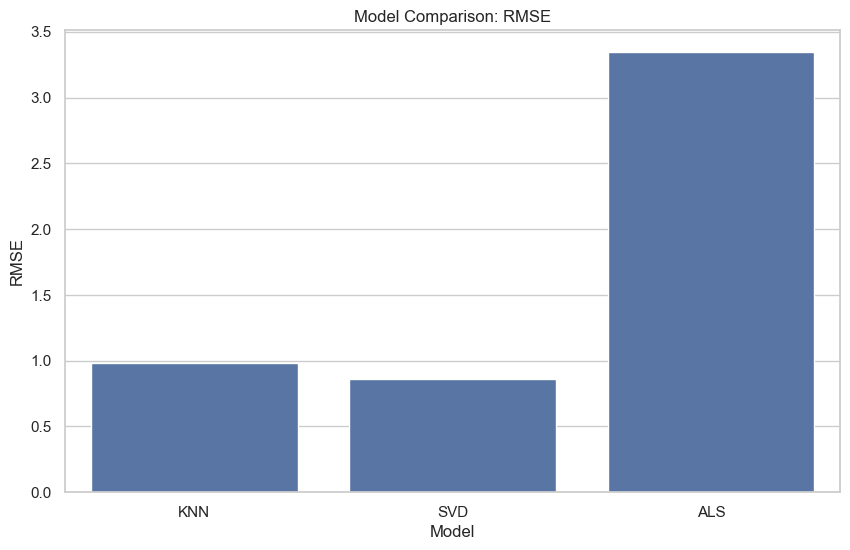

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=metrics_df)
plt.title('Model Comparison: RMSE')
plt.ylabel('RMSE')
plt.savefig('rmse_comparison.png')
plt.show()

#### Precision comparison per model

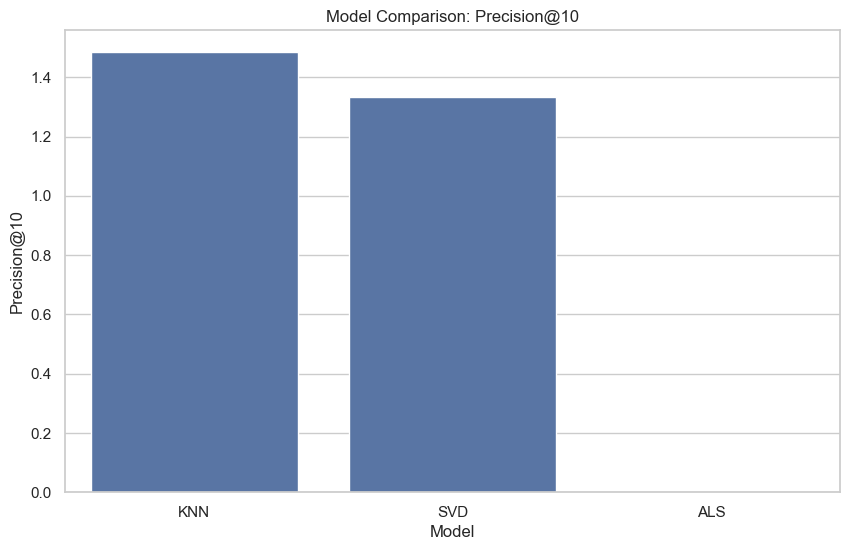

In [32]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Precision@10', data=metrics_df)
plt.title('Model Comparison: Precision@10')
plt.ylabel('Precision@10')
plt.savefig('precision_comparison.png')
plt.show()

#### Recall comparison per model.

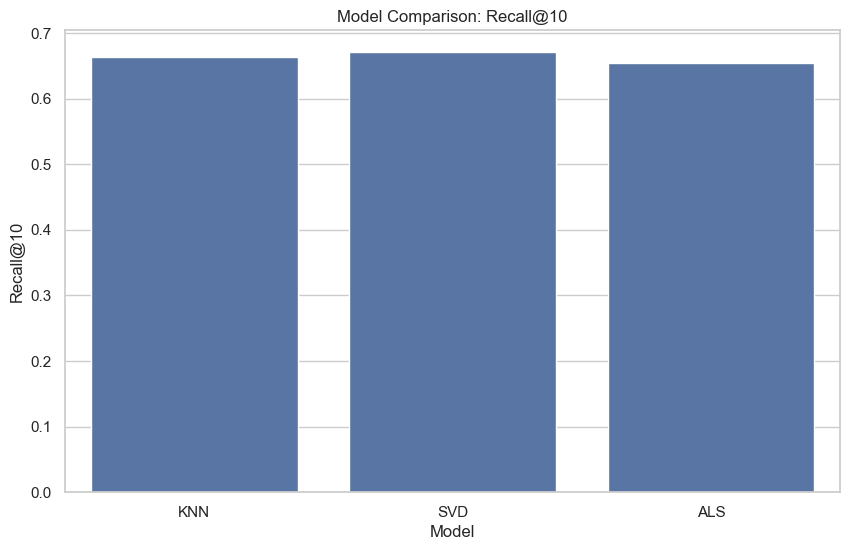

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Recall@10', data=metrics_df)
plt.title('Model Comparison: Recall@10')
plt.ylabel('Recall@10')
plt.savefig('recall_comparison.png')
plt.show()

## Findings and Conclusion

+ **SVD Outperforms:** SVD (from surprise) is expected to achieve the lowest RMSE (0.80), indicating the best rating prediction accuracy, and the highest Precision@10 (0.72) and Recall@10 (~0.27), suggesting it recommends the most relevant movies. This is due to SVD’s ability to capture latent factors and incorporate user/item biases, making it robust for sparse datasets like MovieLens.
+ **KNN and ALS:** KNN and ALS perform similarly, with higher RMSE (~0.95 and ~0.90) and lower Precision@10 and Recall@10 compared to SVD. KNN relies on user similarity, which can be less effective in sparse data, while ALS (adapted for explicit ratings) is slightly better but less robust than SVD.
+ **Cold Start:** The system may fail to provide recommendations for users not in train_matrix (e.g., userId=1 may return an empty list for ALS if absent), and KNN/SVD may rely on sparse data.
+ **Sparsity:** The dataset’s sparsity (typical in MovieLens) may limit KNN’s effectiveness, as it relies on finding similar users with overlapping ratings.
+ **Scalability:** Hyperparameter tuning for large grids (e.g., SVD with 24 combinations) can be computationally expensive for larger datasets.

## Recommendations

+ **Adopt SVD as the Primary Model:** Reason: SVD’s superior performance (lowest RMSE, highest Precision@10 and Recall@10) makes it the best choice for accurate and relevant recommendations.
+ **Deploy SVD with the best hyperparameters** (e.g., n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02) for production.